## Gathering Data - Bing API Search

In [1]:
from fastbook import *
from utils import *
from fastai.vision.widgets import *

To download images with Bing Image Search, sign up at Microsoft for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [2]:
key = '27109ffc3c0649ef853678985f164701'

got the key here: https://azure.microsoft.com/en-us/try/cognitive-services/my-apis/?apiSlug=search-api-v7

In [3]:
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth

I had made an azure account with a previous microsoft account(from IITG) that I had. It was quite different from what is mentioned in [the forum post](https://forums.fast.ai/t/getting-the-bing-image-search-key/67417) mentioned by Jeremy. I had three options while making the account, 1. get a 7 day free trial, 2. Get free Azure account and 3. Get paid subscription. I went for 2. get free azure account. It was repeatedly mentioned that I won't be charged until I upgrade, but when I went to the API page, I see that I have only a 7 day free trial available. I had to give in my Card details though.

In [4]:
def search_images_bing(key, term, min_sz = 128):
    client = api('https://api.cognitive.microsoft.com', auth(key))
    return L(client.images.search(query=term,count = 150, min_height = min_sz, min_width = min_sz).value)

L is a class in fastbook. It is fastai's alternatiive for python lists. 

In [5]:
search_images_bing

<function __main__.search_images_bing(key, term, min_sz=128)>

api actually returns 150 items. There are not links. Each item is a dictionary with some keys. One key is **'content_url'** which is the only thing required for us now. So the L class has an attribute **'attrgot'** which can be used to get the value of a particular key name from all idems, This is done in the next cell.

In [6]:
results = search_images_bing(key, 'soccer ball')
ims = results.attrgot('content_url')
len(ims)

150

## Looking at Some Examples

In [7]:
#for i in results:
#    print(i)

So now **ims** has a list of URLs for soccer ball images. You can download content from a URL at a particular destination like given in the below slide. 

In [8]:
dest = 'images/soccerball1.jpg'
download_url(ims[0], dest)

Image.open() is from PIL library, which does not need to be called separately because it is one of the dependencies which is called when you call 'From fastbook import *'

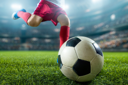

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

## Creating Data Folders

In [10]:
ball_types = 'cricket','soccer','baseball'
path = Path('balls') ## creates a path in current folder

In [11]:
if not path.exists():
    path.mkdir()
    for o in ball_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} ball')
        download_images(dest, urls=results.attrgot('content_url'))

In [12]:
fns = get_image_files(path) ## geting the folder path for all images in balls folder.
## Here all the image paths in all three folders are listed down.  
fns

(#442) [Path('balls/baseball/00000000.jpg'),Path('balls/baseball/00000001.png'),Path('balls/baseball/00000002.jpg'),Path('balls/baseball/00000003.png'),Path('balls/baseball/00000004.png'),Path('balls/baseball/00000005.jpg'),Path('balls/baseball/00000006.jpg'),Path('balls/baseball/00000007.jpg'),Path('balls/baseball/00000008.jpg'),Path('balls/baseball/00000009.jpg')...]

## Removing non-image paths

In [13]:
failed = verify_images(fns) ## checks whether that path contains image or not.
failed

(#0) []

path.unlink deletes files. https://stackoverflow.com/questions/42636018/python-difference-between-os-remove-and-os-unlink-and-which-one-to-use/42636082

.map() calls the function inside the beackets on each element of the object it is attributed to. It is a part of L class. Here, map() calls path.unlink() function on each element of list L=failed.

In [14]:
failed.map(Path.unlink);

## From Data to DataLoaders

ImageDataLoaders is a factory method. We have a more flexible way called DataBlock.

In [15]:
balls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #independent and dependent variable
    get_items=get_image_files, # get list of all filenames needed, See 3rd cell in create data folders section to know about function
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #seed to fix the validation set everytime we run it
    get_y=parent_label, # how do we label the data.(By the name of parent folder, a pre-defined way in pytorch)
    item_tfms=Resize(128)) #resize images

**The workflow of DataBlock**: 

1. get_items is called first. This would list out paths to our entire data.
2. get_x, get_y is called next. This would define the data and labels
3. blocks[0], blocks[1] is called. Need to read more on what these mean. 
4. item_tfms are called to include all the required transformations of independent var.\
---------> splitter is called which splits the data into training and validation\

5. A dataloader is called. Dataloader takes a batch(default 64) images so that this batch is run together on the GPU.
6. batch_tfms: later

Datablocks return a dataloader a training and validation dataloaders. Dataloaders are a set of 64 images stacked together for one GPU run.\ 
Dataloaders.train creates a training batch and dataloaders.valid creates a validation batch. Right now, it seems like a dataloader takes some images and does the augmentation and send it to model.

## Data Augmentation

### 1. Resizing

item_tfms = Resize(x), changes the size of images to x by x.\
How?
**Different Types of Resizes:** 
1. Squish: we squish any rectangle to size. Images would be different, bears might look fatter, balls could go oval.
2. Pad: we resize so that the shorter dimension is a match an use padding with pad_mode. Best method in terms of information retaining, but could lead to procssing of lot of zero-value pixels
3. Crop: we resize so that the larger dimension is match and crop (randomly on the training set, center crop for the validation set). We lose information

In [16]:
dls = balls.dataloaders(path) ## creating dataloaders.

In [17]:
path # the folder with data is given to dataloaders as input

Path('balls')

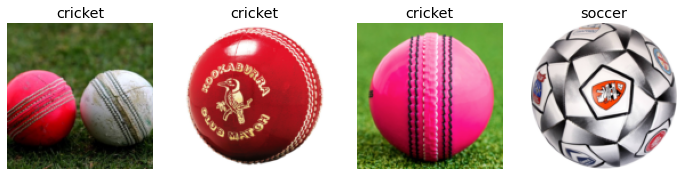

In [18]:
dls.valid.show_batch(max_n=4, nrows=1) # to see a batch from one validation dataloader

**Datablock.new** attribute: Create a new datablock which is an exact copy of the previous one, with some changes. I will use new() attribute to create a new datablock but with a different image transform.

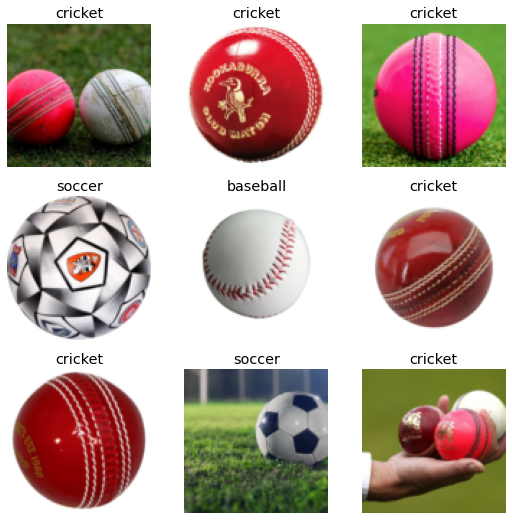

In [19]:
balls = balls.new(item_tfms = Resize(100))
dls = balls.dataloaders(path)
dls.valid.show_batch()

### 2. RandomResizedCrop

1. min_scale = atlease this much percentage of pixels need to be involved.
2. unique = True, show_batch for same image.

On the validation set, we center crop the image if it's ratio isn't in the range (to the minmum or maximum value) then resize.

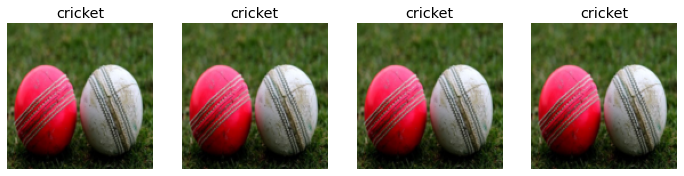

In [20]:
balls = balls.new(item_tfms = RandomResizedCrop(128, min_scale = 0.3))
dls = balls.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, unique = True)

On the train set, random cropping takes place where scale in range (min_scale,1).

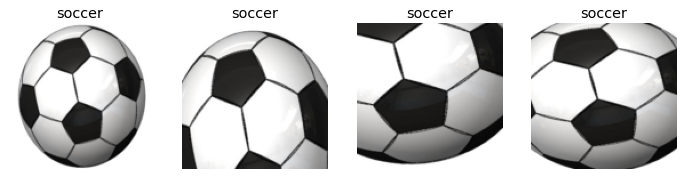

In [21]:
dls.train.show_batch(max_n=4, nrows=1, unique = True)

### 3. Batch_tfms

item_tfms is done on each individual image and once we set all images to same size, batch transforms can be done. Few points about batch transforms:
1. done on an entire batch after loading that bach to GPU(loading using dataloaders)
2. for natural rgb images, there's a set of augmentations proved to work very well. These have been compiled in the **aug_transforms()** class. It provides a list of different transformations.
3. aug_transforms, by default are only applied to training dataloaders. 

In [ ]:
doc(aug_transforms)

aug_transforms(mult=1.0, do_flip=True, flip_vert=False, max_rotate=10.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None, size=None, mode='bilinear', pad_mode='reflection', align_corners=True, batch=False, min_scale=1.0)\

Random flip (or dihedral if flip_vert=True) with p=0.5 is added when do_flip=True. 
With p_affine we apply a random rotation of max_rotate degrees, a random zoom between min_zoom and max_zoom and a perspective warping of max_warp. With p_lighting we apply a change in brightness and contrast of max_lighting. Custon xtra_tfms can be added. size, mode and pad_mode will be used for the interpolation. max_rotate,max_lighting,max_warp are multiplied by mult so you can more easily increase or decrease augmentation with a single parameter.



**p_affine, p_lighting, p** could be percentage of images assigned to undergo each kind of augmentation

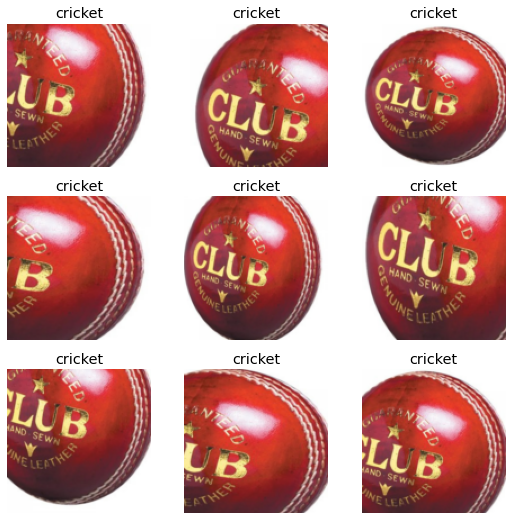

In [19]:
balls = balls.new(item_tfms = RandomResizedCrop(128, min_scale = 0.3))
                 ##, batch_tfms = aug_transforms(mult = 2)) can't run this due to memory error
dls = balls.dataloaders(path)
dls.train.show_batch( unique = True) #train dataloader is augmented. shft + tab in the 
#aug_transforms() bracket to see transforms applied.

In [ ]:
dls.valid.show_batch( unique = True) ## no augmentations on valid dataloader

## Training Your Model

In [22]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: U

**RuntimeError: DataLoader worker (pid 9945) is killed by signal: Killed.**
        
If you're using the docker to run the PyTorch program, with high probability, it's because the shared memory of docker is NOT big enough for running your program in the specified batch size.

The solutions for this circumstance are:

use a smaller batch size to train your model.
exit the current docker, and re-run the docker with specified "--shm-size=16g" or bigger shared memory space depending on your machine.
Hope this could help those who have the same problem .
        

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


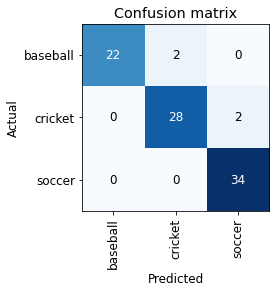

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

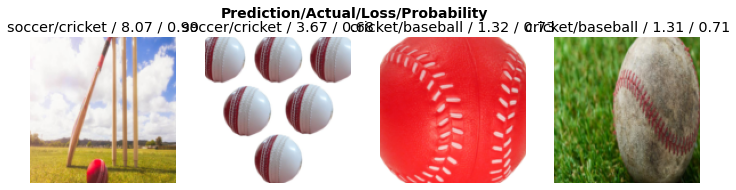

In [24]:
interp.plot_top_losses(4, nrows=1)

## Data Cleaning

Data cleaning normally happens before training. But lately, we can actually use the model outputs like plot_top_losses to do better data cleaning. I personally think that this User Itercative method of data cleaning is only useful in case of small datasets. It will show the images which lead to top losses and we can change the label/delete/keep those images. We normally prefer to train a short baseline model first and then clean the data by looking at the top losses

You can select top losses for validation and train set and decide what you want to clean and also which class you want to clean.\
From here, we can deal with the high loss data in training sample. Since all other data has lower losses, we can assume that they must be fine too. 

In [24]:
doc(plot_top_losses)

In [25]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Right now, cleaner object has all the images in Cricket class from the Train data. 
So cleaner.fns = List of all file paths shown above. and cleaner.delete() and cleaner.change() return all the indices in cleaner.fns which we marked to delete or which we changes the classes. 

In [26]:
print(cleaner.delete()) #list of indexes(for cleaner.fns) which were deleted from above
print(cleaner.change()) #list of (image indexes from cleaner.fns, correct class) which were changed from one class to another
print(cleaner.fns)

(#0) []
(#0) []
(#30) [Path('balls/baseball/00000119.png'),Path('balls/baseball/00000138.jpg'),Path('balls/baseball/00000076.gif'),Path('balls/baseball/00000101.png'),Path('balls/baseball/00000066.png'),Path('balls/baseball/00000030.png'),Path('balls/baseball/00000065.jpg'),Path('balls/baseball/00000094.jpg'),Path('balls/baseball/00000087.jpg'),Path('balls/baseball/00000099.jpg')...]


In [27]:
#Doing the changes in files
for idx in cleaner.delete(): 
    cleaner.fns[idx].unlink() #delete files which were marked above
for idx,cat in cleaner.change(): #cleaner.change() is a list of tuples
    shutil.move(str(cleaner.fns[idx]), path/cat) # change paths to correct class

## Exporting Model to a .pkl File

In [28]:
learn.export() # exporting model in learn object as a pkl file

In [29]:
path1 = Path() # path to the current folder. Path() is used to define a path
path1

Path('.')

In [30]:
path1.ls(file_exts = '.pkl') # list all files with .pkl extension

(#1) [Path('export.pkl')]

In [31]:
learn_inf = load_learner(path1/'export.pkl') # load weights

In [32]:
learn_inf.predict('images/sachin_signed_ball.jpg') # this image is and out of sample image of cricket
#ball signed by sachin. Our Model works!!

('cricket', tensor(1), tensor([0.0196, 0.8899, 0.0905]))

('cricket', tensor(1), tensor([6.0704e-04, 9.7703e-01, 2.2365e-02]))

1. The class that our model predicts
2. That class's index in learn_inf.dls.vocab
3. probability/confidence for each class in the order as given in learn_inf.dls.vocab

the inference part of our model(learn_inf) already knows the class names because dataloader is also loaded with our weights in load_learner object. Hence we have the Vocab and the class names. dataloader can be called from load_learner() object.


In [33]:
print(learn_inf.dls)
print(learn_inf.dls.vocab)

(#3) ['baseball','cricket','soccer']


## Creating a Notebook App

### Widgets: FileUpload

In [80]:
btn_upload = widgets.FileUpload(
    accept='',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False)  # True to accept multiple files upload else False

btn_upload #placeholder for uploader button

FileUpload(value={}, description='Upload')

### Widgets: Output

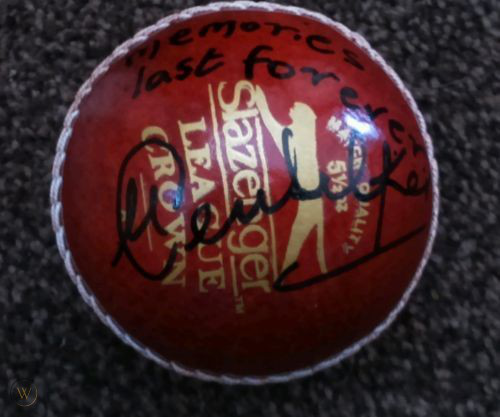

In [82]:
img = PILImage.create(btn_upload.data[-1]) # store image that's uploaded
img

In [83]:
out_pl = widgets.Output()
out_pl.clear_output()
out_pl #Shows no output yet. Once out_pl is filled, then shows value at placeholder

Output()

In [55]:
with out_pl: 
    display(img.to_thumb(128,128)) #output is shown from your end, so this code
#display is quite a handy function, you can display youtube videos too

### Widgets:label, used to show the prediction result

In [94]:
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label('Here is the ball')
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: cricket; Probability: 0.8899')

### Widgets:Run, used to run classifier

In [59]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [85]:
def on_click_classify(change):    #function to run on click event on classify button
    
    img = PILImage.create(btn_upload.data[-1]) #save image uploaded
    out_pl.clear_output() #clear the output display
    with out_pl: display(img.to_thumb(128,128)) # set new output display
    pred,pred_idx,probs = learn_inf.predict(img) #learn_inf.predict gives 3 values seen above
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}' #setting label value

btn_run.on_click(on_click_classify)

## Bringing all widgets together

In [98]:
btn_upload1 = widgets.FileUpload(
    accept='',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False)

out_pl1 = widgets.Output()

lbl_pred1 = widgets.Label('Here is the ball')

btn_run1 = widgets.Button(description='Classify')

btn_run1.on_click(on_click_classify)

This cell below is the essence, here we define what needs to be done in the function, and when is the function triggered.

In [99]:
#steps
# 1. store image
# 2. clear the previousoutput
# 3. show the new output
# 4. run the learned inference and get the probability values and prediction
# 5. model.predict gives 1.prediction, 2. index of prediction in vocab, 3. probability
# of each class in the same order as in vocab. So the 2nd term(index) can be used to find 
# probability with which the predicted class is supported.

def on_click_classify(change):    #function to run on click event
    img = PILImage.create(btn_upload1.data[-1]) #save image uploaded
    out_pl1.clear_output() #clear the output display
    with out_pl1: display(img.to_thumb(128,128)) # set new output display
    pred,pred_idx,probs = learn_inf.predict(img) #learn_inf.predict gives 3 values seen above
    lbl_pred1.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}' #setting label value

btn_run1.on_click(on_click_classify) #defining the event and defining the function

# Here's the App

In [100]:
VBox([widgets.Label('Select your ball!'), 
      btn_upload1, btn_run1, out_pl1, lbl_pred1])